# Importing libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import hist
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import itertools 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

# EDA

In [2]:
df_merge = pd.read_csv('merge_data.csv')
df_merge = df_merge.drop('Unnamed: 0', 1)
df_merge.head()

,publisher,author,isbn,date,title,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
0,St. Martin's,Kristin Hannah,125016561X,2018-06-09,THE GREAT ALONE,16,3,151,243,48,363073,778639,36575,4.34
1,Ballantine,Jodi Picoult,034554496X,2017-02-12,SMALL GREAT THINGS,16,3,104,172,35,260815,533873,25170,4.34
2,Grand Central,Nicholas Sparks,1455520691,2017-02-05,TWO BY TWO,16,3,2015,8889,353,66630,163159,5816,3.92
3,Harper,Harper Lee,0062409875,2016-07-10,GO SET A WATCHMAN,16,4,54,96,17,229380,575055,29495,3.31
4,Scribner,Stephen King,1501175467,2017-12-10,IT,15,1,1333,2982,190,789789,1398689,25068,4.24


In [3]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   publisher                1215 non-null   object 
 1   author                   1215 non-null   object 
 2   isbn                     1215 non-null   object 
 3   date                     1215 non-null   object 
 4   title                    1215 non-null   object 
 5   weeks_on_list            1215 non-null   int64  
 6   no_of_words_title        1215 non-null   int64  
 7   ratings_count            1215 non-null   int64  
 8   reviews_count            1215 non-null   int64  
 9   text_reviews_count       1215 non-null   int64  
 10  work_ratings_count       1215 non-null   int64  
 11  work_reviews_count       1215 non-null   int64  
 12  work_text_reviews_count  1215 non-null   int64  
 13  average_rating           1215 non-null   float64
dtypes: float64(1), int64(8),

### Distribution of Review and Rating Counts

(array([  1560.03732886,   6760.16175838,  25480.60970467,  88402.11530193,
        169524.05640253, 171084.09373138, 108682.60057708,  40560.9705503 ,
         10400.24885905,   1560.03732886]),
 array([-3.96957885, -3.20223611, -2.43489338, -1.66755064, -0.9002079 ,
        -0.13286516,  0.63447758,  1.40182032,  2.16916305,  2.93650579,
         3.70384853]),
 <a list of 10 Patch objects>)

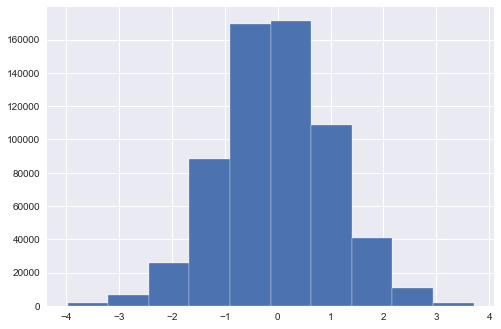

In [4]:
# Distribution of work_text_reviews_count
df = pd.DataFrame({'work_text_reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.work_text_reviews_count, weights=df.weeks_on_list)

(array([  4217.73481129,   8435.46962258,  42177.34811288, 162382.79023458,
        289969.26827603, 336364.3512002 , 265717.29311113, 101225.63547091,
         46395.08292417,   8435.46962258]),
 array([-3.65327826, -2.97600292, -2.29872758, -1.62145225, -0.94417691,
        -0.26690157,  0.41037377,  1.08764911,  1.76492445,  2.44219979,
         3.11947513]),
 <a list of 10 Patch objects>)

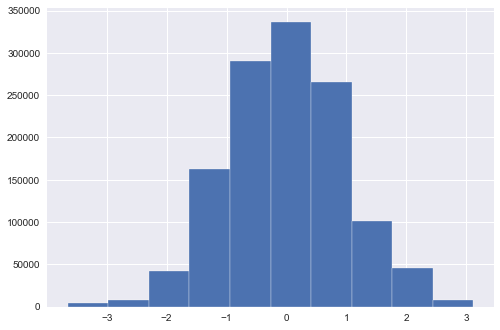

In [5]:
# Distribution of work_reviews_count
df = pd.DataFrame({'work_reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.work_reviews_count, weights=df.weeks_on_list)

(array([  5518.52509261,  15451.8702593 ,  71740.82620391, 168866.86783382,
        289170.71485268, 334422.62061207, 228466.93883399, 157829.8176486 ,
         41940.79070382,  11037.05018522]),
 array([-3.46566763, -2.81534665, -2.16502568, -1.5147047 , -0.86438372,
        -0.21406274,  0.43625824,  1.08657921,  1.73690019,  2.38722117,
         3.03754215]),
 <a list of 10 Patch objects>)

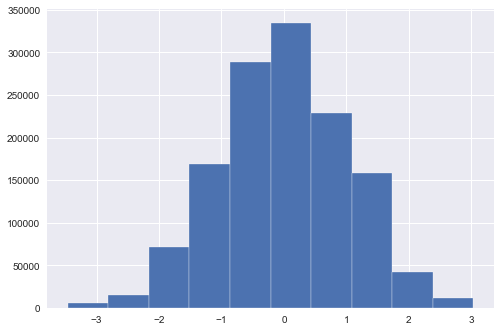

In [6]:
# Distribution of work_ratings_count
df = pd.DataFrame({'work_ratings_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.work_ratings_count, weights=df.weeks_on_list)

(array([  7186.53025863,  16768.57060346,  55695.60950436, 116182.23918114,
        165889.07346997, 183855.39911654, 106001.32131475,  49107.95676728,
         14373.06051725,   3593.26512931]),
 array([-3.09802447, -2.47488877, -1.85175306, -1.22861736, -0.60548165,
         0.01765405,  0.64078976,  1.26392546,  1.88706117,  2.51019687,
         3.13333258]),
 <a list of 10 Patch objects>)

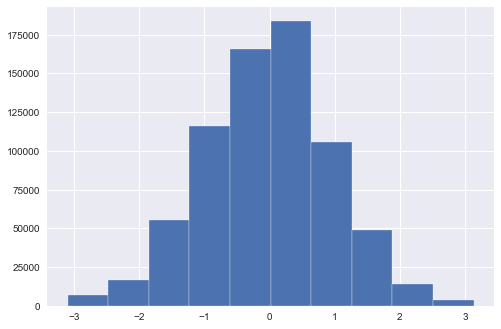

In [7]:
# Distribution of text_reviews_count
df = pd.DataFrame({'text_reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.text_reviews_count, weights=df.weeks_on_list)

(array([  1328.38773683,   4427.95912276,  30552.91794707,  75275.30508698,
        126196.83499876, 135938.34506884,  89887.5701921 ,  46493.57078902,
         17711.83649105,   3542.36729821]),
 array([-3.29803086, -2.65918888, -2.02034691, -1.38150494, -0.74266297,
        -0.103821  ,  0.53502097,  1.17386294,  1.81270491,  2.45154688,
         3.09038885]),
 <a list of 10 Patch objects>)

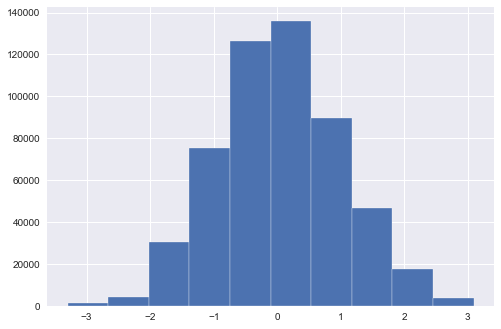

In [8]:
# Distribution of ratings_count
df = pd.DataFrame({'ratings_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.ratings_count, weights=df.weeks_on_list)

(array([  3692.43391729,  10154.19327253,  58155.83419725, 187391.02130224,
        276009.43531709, 298164.0388208 , 189237.23826088,  64617.5935525 ,
         15692.84414846,   4615.54239661]),
 array([-3.58392529, -2.88134331, -2.17876134, -1.47617936, -0.77359738,
        -0.07101541,  0.63156657,  1.33414855,  2.03673053,  2.7393125 ,
         3.44189448]),
 <a list of 10 Patch objects>)

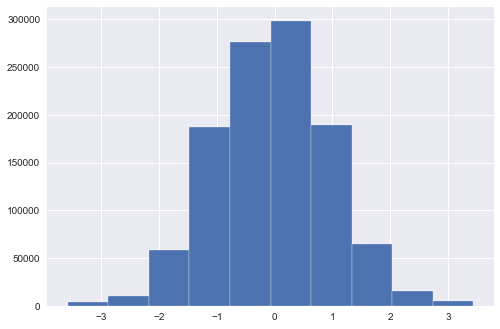

In [9]:
# Distribution of reviews_count
df = pd.DataFrame({'reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.reviews_count, weights=df.weeks_on_list)

### Average Rating and Number of Words in Title

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CAF7F0E508>,
      dtype=object)

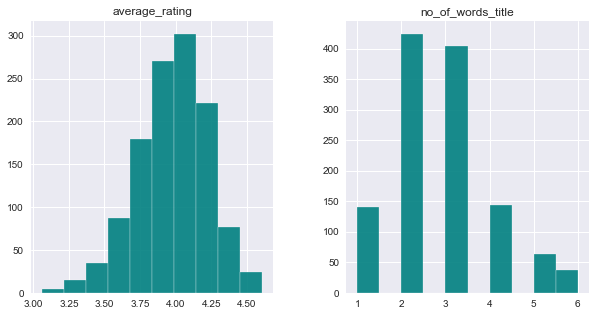

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
df_merge[['average_rating','no_of_words_title']].hist(bins=10, color='teal', alpha=0.9, ax=ax)

### Top 20 Publishers with the most best selling books

In [11]:
publisher_list = df_merge['publisher'].to_list()

In [12]:
publisher_list

["St. Martin's",
 'Ballantine',
 'Grand Central',
 'Harper',
 'Scribner',
 'Grand Central',
 'Grand Central',
 'Delacorte',
 'Doubleday',
 'Grand Central',
 'Riverhead',
 'Sarah Crichton/Farrar, Straus & Giroux',
 'Delacorte Press',
 'Grand Central',
 'Grand Central',
 'Delacorte',
 'Berkley',
 'Grand Central',
 'Little, Brown',
 'Grand Central',
 'Putnam',
 'Knopf',
 'Knopf Doubleday',
 'Vintage',
 'Viking',
 'Flatiron',
 'Grand Central',
 'Delacorte',
 'Grand Central',
 'Grand Central',
 'Little, Brown',
 "St. Martin's",
 'Algonquin',
 'Grand Central',
 'Bantam',
 'Random House',
 'Picador',
 'Scribner',
 'Delacorte',
 'Broadway',
 'Little, Brown & Company',
 'Random House Publishing',
 'Grand Central',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown',
 'Scribner',
 'Scribner',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown & Company',
 'Putnam',
 'Little, Brown',
 'Delacorte',
 'Putnam',
 'Simon & Schuster',
 'Little, Brown',
 'Little, Br

In [13]:
# Convert any of the iterable to sequence of iterable publishers with dintinct publishers
unique_publishers = set(publisher_list)

In [14]:
# Count the number of books for each publisher
num_publisher = {}
for publisher in unique_publishers:
    num_publisher[publisher] = publisher_list.count(publisher)
    
num_publisher

{'Knopf': 18,
 'Hyperion Press': 3,
 'Tom Doherty Associates': 2,
 'Pantheon': 1,
 'Harlequin': 38,
 'Little, Brown & Company': 14,
 'ROC': 2,
 'Morrow': 25,
 'ePublishing Works!': 1,
 'Delacorte Press': 1,
 'Kathleen Brooks': 1,
 'Minotaur': 13,
 'Viking': 7,
 'Random House': 41,
 'Crown Publishing': 1,
 'Knopf Doubleday': 10,
 'Zebra/Mulholland': 1,
 'Avon/HarperCollins': 4,
 'Bloomsbury': 1,
 'EverAfter Romance': 1,
 'Vintage': 5,
 'Harper/HarperCollins': 5,
 'Flatiron': 2,
 'Laurelin Paige': 1,
 'JKB': 2,
 'Spencer Hill Contemporary': 1,
 'Mulholland/Little, Brown': 3,
 'Sourcebooks': 1,
 'Forever/Grand Central': 1,
 'Hyperion': 2,
 'Nan A. Talese/Doubleday': 1,
 "Knopf/McSweeney's": 1,
 'Wizards of the Coast': 1,
 'Anchor': 3,
 'Dutton': 9,
 'Atria Books': 3,
 'Mariner': 2,
 'Zebra/Kensington': 1,
 'Harper': 22,
 'Little, Brown': 65,
 'HTJB': 2,
 "St. Martin's Griffin": 5,
 'Sapphire Star Publishing': 1,
 'Howard': 1,
 'Harlequin HQN': 3,
 'Scout': 1,
 'Reagan Arthur/Little, Brown

In [15]:
# Sort the publisher list from the highest to the lowest number of books
num_publisher = {k: v for k, v in sorted(num_publisher.items(), key=lambda item: item[1], 
                                         reverse=True)}

In [16]:
# Review the list
num_publisher

{'Simon & Schuster': 67,
 'Little, Brown': 65,
 'Grand Central': 59,
 "St. Martin's": 54,
 'Putnam': 46,
 'Random House': 41,
 'Random House Publishing': 40,
 'Harlequin': 38,
 'Delacorte': 36,
 'Morrow/HarperCollins': 33,
 'Ballantine': 32,
 'HarperCollins Publishers': 30,
 'Avon': 29,
 'Morrow': 25,
 'Bantam': 25,
 'Harper': 22,
 'Atria': 21,
 'HarperCollins': 21,
 'HQN': 20,
 'Mira': 20,
 'Berkley': 19,
 'Grand Central Publishing': 19,
 "St. Martin's Press": 19,
 'Penguin Group': 19,
 'Knopf': 18,
 'Scribner': 18,
 'Del Rey': 15,
 'Little, Brown & Company': 14,
 'Minotaur': 13,
 'Zebra': 12,
 'Touchstone': 11,
 'Gallery': 11,
 'Knopf Doubleday': 10,
 'Doubleday': 10,
 'Dutton': 9,
 'Gallery Books': 9,
 'Knopf Doubleday Publishing': 9,
 'Kensington': 8,
 'Viking': 7,
 'Ace': 7,
 'BookShots': 6,
 'Harlequin Mira': 6,
 'Emily Bestler/Atria': 6,
 'Vintage': 5,
 'Harper/HarperCollins': 5,
 "St. Martin's Griffin": 5,
 'Orbit': 5,
 'Forever': 5,
 'Farrar, Straus & Giroux': 5,
 'Howard Book

In [17]:
# Make another list with Top 20 publishers with the higest number of best selling books
publisher_20 = dict(itertools.islice(num_publisher.items(), 20))

In [18]:
publisher_20

{'Simon & Schuster': 67,
 'Little, Brown': 65,
 'Grand Central': 59,
 "St. Martin's": 54,
 'Putnam': 46,
 'Random House': 41,
 'Random House Publishing': 40,
 'Harlequin': 38,
 'Delacorte': 36,
 'Morrow/HarperCollins': 33,
 'Ballantine': 32,
 'HarperCollins Publishers': 30,
 'Avon': 29,
 'Morrow': 25,
 'Bantam': 25,
 'Harper': 22,
 'Atria': 21,
 'HarperCollins': 21,
 'HQN': 20,
 'Mira': 20}

In [19]:
# Make 2 lists for name of publishers and number of books
publishers = []
counts = []

for publisher, count in publisher_20.items():
    publishers.append(publisher)
    counts.append(count)

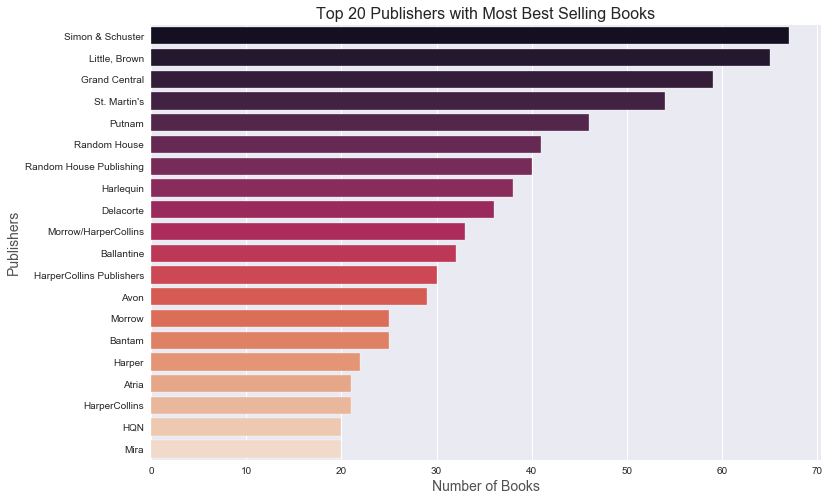

In [20]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr1 = sns.barplot(x=counts, y=publishers,
                  ci=None, palette='rocket')
gr1.set_xlabel('Number of Books', fontsize=14, alpha=0.8)
gr1.set_ylabel('Publishers', fontsize=14, alpha=0.8)
gr1.set_title('Top 20 Publishers with Most Best Selling Books', fontsize=16)
plt.show()

### Top 20 Authors with the most best selling books

In [21]:
author_list = df_merge['author'].to_list()

In [22]:
# Convert any of the iterable to sequence of iterable authors with dintinct authors
unique_authors = set(author_list)

In [23]:
# Count the number of books for each author
num_author = {}
for author in unique_authors:
    num_author[author] = author_list.count(author)
    
num_author

{'Jeffrey Eugenides': 1,
 'Christina Lauren': 9,
 'James Patterson with Richard DiLallo': 1,
 'Tess Gerritsen': 7,
 'Nora Roberts': 12,
 'Sherryl Woods': 4,
 'Barbara Kingsolver': 1,
 'Jessica Sorensen': 2,
 'Randy Wayne White': 2,
 'Chuck Wendig': 3,
 'Susan Mallery': 20,
 'Harlan Coben': 4,
 'Mary Higgins Clark and Alafair Burke': 4,
 'Iris Johansen': 11,
 'Guillermo del Toro and Chuck Hogan': 1,
 'James Patterson and Maxine Paetro': 11,
 'Jamie McGuire': 4,
 'A L Jackson': 1,
 'Sarah MacLean': 3,
 'Glenn Beck': 2,
 'Maria Semple': 1,
 'Eric Rickstad': 1,
 'Dennis Lehane': 2,
 'Hazel Gaynor': 1,
 'Ken Follett': 3,
 'Liliana Hart': 1,
 'Michelle Gable': 1,
 'Kathleen Grissom': 1,
 'Garth Risk Hallberg': 1,
 'Annie Barrows': 1,
 'Lisa Jewell': 2,
 'Michael Chabon': 2,
 'Carl Hiaasen': 1,
 'Kim Harrison': 3,
 'Gena Showalter': 3,
 'Linda Howard': 4,
 'Jennifer McMahon': 1,
 'Lisa Genova': 1,
 'James Patterson and Howard Roughan': 3,
 'J D Robb': 4,
 'Greg Iles': 3,
 'Lisa See': 1,
 'Lis

In [24]:
# Sort the author list from the highest to the lowest number of books
num_author = {k: v for k, v in sorted(num_author.items(), key=lambda item: item[1], 
                                         reverse=True)}

In [25]:
# Review the list
num_author

{'Danielle Steel': 25,
 'Susan Mallery': 20,
 'David Baldacci': 18,
 'Ron Carr': 17,
 'Janet Evanovich': 13,
 'J A Jance': 13,
 'Nora Roberts': 12,
 'Michael Connelly': 12,
 'Debbie Macomber': 12,
 'Lee Child': 12,
 'Iris Johansen': 11,
 'James Patterson and Maxine Paetro': 11,
 'Linda Lael Miller': 11,
 'Lisa Scottoline': 11,
 'Karen Kingsbury': 11,
 'Jill Shalvis': 10,
 'Douglas Preston and Lincoln Child': 10,
 'Dean Koontz': 10,
 'Stephen King': 10,
 'Sandra Brown': 10,
 'Christina Lauren': 9,
 'Elin Hilderbrand': 9,
 'John Grisham': 9,
 'Mary Higgins Clark': 9,
 'Fern Michaels': 9,
 'Lynsay Sands': 9,
 'Maya Banks': 8,
 'Dorothea Benton Frank': 8,
 'Richard Paul Evans': 8,
 'Kristin Hannah': 8,
 'Kresley Cole': 8,
 'Philippa Gregory': 8,
 'James Patterson and Michael Ledwidge': 8,
 'James Patterson': 8,
 'Marie Force': 8,
 'Tess Gerritsen': 7,
 'Steve Berry': 7,
 'Nicholas Sparks': 7,
 'Lisa Jackson': 7,
 'James Rollins': 6,
 'Karin Slaughter': 6,
 'Jeffery Deaver': 6,
 'George R R

In [26]:
# Make another list with Top 20 authors with the higest number of best selling books
author_20 = dict(itertools.islice(num_author.items(), 20))

In [27]:
author_20

{'Danielle Steel': 25,
 'Susan Mallery': 20,
 'David Baldacci': 18,
 'Ron Carr': 17,
 'Janet Evanovich': 13,
 'J A Jance': 13,
 'Nora Roberts': 12,
 'Michael Connelly': 12,
 'Debbie Macomber': 12,
 'Lee Child': 12,
 'Iris Johansen': 11,
 'James Patterson and Maxine Paetro': 11,
 'Linda Lael Miller': 11,
 'Lisa Scottoline': 11,
 'Karen Kingsbury': 11,
 'Jill Shalvis': 10,
 'Douglas Preston and Lincoln Child': 10,
 'Dean Koontz': 10,
 'Stephen King': 10,
 'Sandra Brown': 10}

In [28]:
# Make 2 lists for name of publishers and number of books
authors = []
counts = []

for author, count in author_20.items():
    authors.append(author)
    counts.append(count)

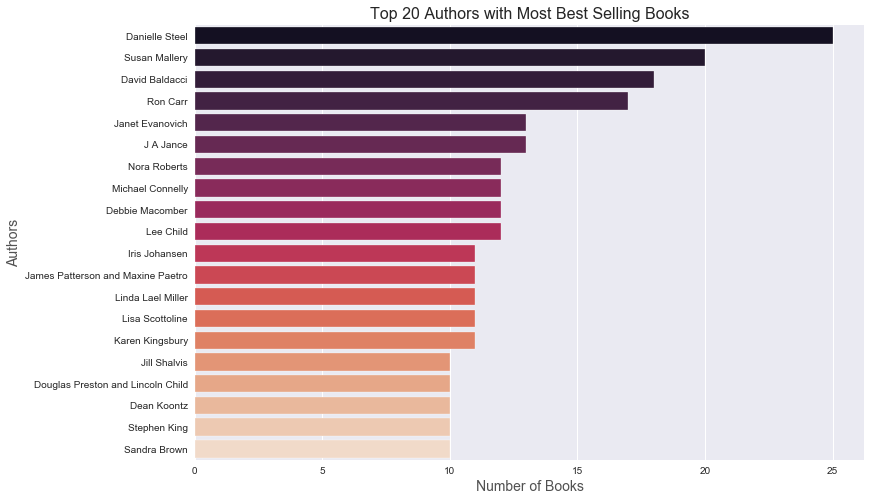

In [29]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr2 = sns.barplot(x=counts, y=authors,
                  ci=None, palette='rocket')
gr2.set_xlabel('Number of Books', fontsize=14, alpha=0.8)
gr2.set_ylabel('Authors', fontsize=14, alpha=0.8)
gr2.set_title('Top 20 Authors with Most Best Selling Books', fontsize=16)
plt.show()

### Best Sellers Trend by Years

In [30]:
# Change the format of 'date' column
df_merge['date'] = pd.to_datetime(df_merge['date'])
print(df_merge['date'].dtype)

datetime64[ns]


In [31]:
# Extract the year from 'date' column and put it in a new column 'year'
df_merge['year'] = pd.DatetimeIndex(df_merge['date']).year
df_merge.head()

,publisher,author,isbn,date,title,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating,year
0,St. Martin's,Kristin Hannah,125016561X,2018-06-09,THE GREAT ALONE,16,3,151,243,48,363073,778639,36575,4.34,2018
1,Ballantine,Jodi Picoult,034554496X,2017-02-12,SMALL GREAT THINGS,16,3,104,172,35,260815,533873,25170,4.34,2017
2,Grand Central,Nicholas Sparks,1455520691,2017-02-05,TWO BY TWO,16,3,2015,8889,353,66630,163159,5816,3.92,2017
3,Harper,Harper Lee,0062409875,2016-07-10,GO SET A WATCHMAN,16,4,54,96,17,229380,575055,29495,3.31,2016
4,Scribner,Stephen King,1501175467,2017-12-10,IT,15,1,1333,2982,190,789789,1398689,25068,4.24,2017


In [32]:
yr_list = df_merge['year'].to_list()

In [33]:
# Convert any of the iterable to sequence of iterable years with dintinct years
unique_yrs = set(yr_list)

In [34]:
# Count the number of books for each year
num_yr = {}
for yr in unique_yrs:
    num_yr[yr] = yr_list.count(yr)

In [35]:
# Sort the year list in order of 2011 to 2018
num_yr = dict(sorted(list(num_yr.items())))
num_yr

{2011: 143,
 2012: 137,
 2013: 131,
 2014: 142,
 2015: 172,
 2016: 248,
 2017: 169,
 2018: 73}

In [36]:
# Make 2 lists for years and number of books
yrs = []
counts = []

for yr, count in num_yr.items():
    yrs.append(yr)
    counts.append(count)

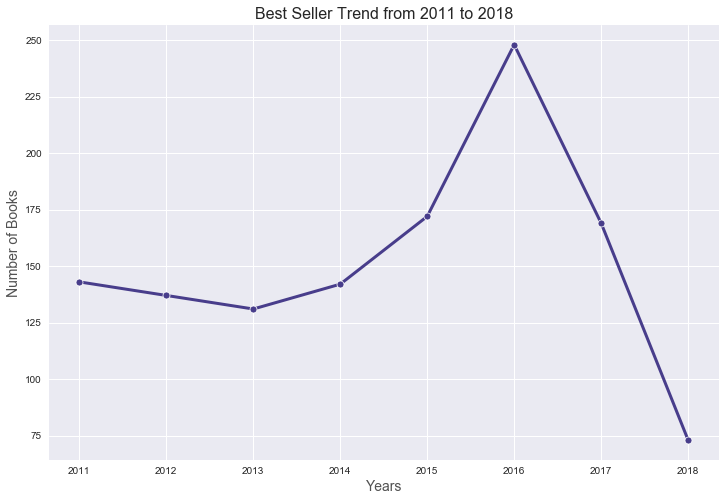

In [37]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr3 = sns.lineplot(yrs, counts, ci=None, marker='o', color='darkslateblue', linewidth=3)
gr3.set_ylabel('Number of Books', fontsize=14, alpha=0.8)
gr3.set_xlabel('Years', fontsize=14, alpha=0.8)
gr3.set_title('Best Seller Trend from 2011 to 2018', fontsize=16)
plt.show()

In [38]:
df_merge['weeks_on_list'].value_counts(normalize=True)

1     0.426337
0     0.386831
2     0.052675
4     0.030453
3     0.025514
6     0.017284
5     0.017284
8     0.010700
7     0.007407
9     0.006584
10    0.004938
16    0.003292
15    0.002469
13    0.002469
14    0.002469
11    0.001646
12    0.001646
Name: weeks_on_list, dtype: float64

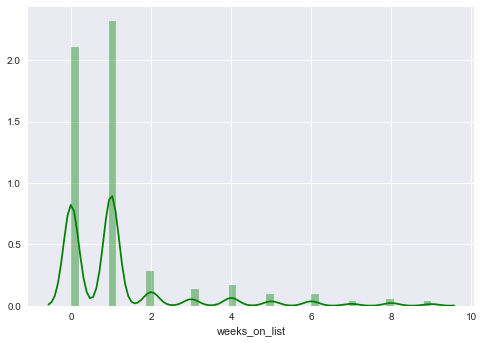

In [39]:
df1 = df_merge.loc[(df_merge['weeks_on_list'] < 10)].copy()
sns.distplot(df1['weeks_on_list'], kde=True, color="green")

In [40]:
cols_of_interest = ['weeks_on_list','no_of_words_title','ratings_count','reviews_count','text_reviews_count',
                    'work_ratings_count','work_reviews_count','work_text_reviews_count','average_rating']
df_merge = df_merge[cols_of_interest]

In [41]:
df_merge.describe()

,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
count,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1.215000e+03,1215.000000,1215.000000
mean,1.360494,2.736626,3751.211523,7941.692181,390.095473,44806.940741,8.466811e+04,3447.869136,3.976741
std,2.317846,1.164310,11864.112871,24450.464957,1151.049818,91514.465811,1.574557e+05,5754.555105,0.251159
min,0.000000,1.000000,0.000000,0.000000,0.000000,45.000000,1.770000e+02,2.000000,3.060000
25%,0.000000,2.000000,21.000000,42.000000,5.000000,7042.000000,1.508450e+04,623.500000,3.820000
50%,1.000000,3.000000,80.000000,146.000000,18.000000,15924.000000,3.180500e+04,1404.000000,3.990000
75%,1.000000,3.000000,676.000000,1446.500000,104.000000,40904.000000,7.837450e+04,3397.500000,4.150000
max,16.000000,6.000000,105021.000000,184021.000000,9413.000000,886392.000000,1.398689e+06,47031.000000,4.610000


# Train-Test Split 

In [42]:
# first split the data into a train-test split and don't touch the test set yet
train_df, test_df = train_test_split(df_merge, test_size=0.2, random_state=42)

# next, split the training set into a train-validation split
# the test-size is 0.25 since we are splitting 80% of the data into 20% and 60% overall
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print('Train Set: {0:0.2f}%'.format(100*train_df.size/df_merge.size))
print('Validation Set: {0:0.2f}%'.format(100*val_df.size/df_merge.size))
print('Test Set: {0:0.2f}%'.format(100*test_df.size/df_merge.size))

Train Set: 60.00%
Validation Set: 20.00%
Test Set: 20.00%


In [43]:
X = train_df[cols_of_interest]
y = train_df['weeks_on_list']
print(X.shape)
print(y.shape)

(729, 9)
(729,)


# Scale data with StandardScaler

* Standardization maintains outliers (do you see why?) whereas normalization makes outliers less obvious. In applications where outliers are useful, standardization should be done.
* StandardScaler() will transform each value in the column to range about the mean 0 and standard deviation 1, ie, each value will be normalised by subtracting the mean and dividing by standard deviation. Use StandardScaler if you know the data distribution is normal.

In [44]:
features = ['no_of_words_title','ratings_count','reviews_count','text_reviews_count',
            'work_ratings_count','work_reviews_count','work_text_reviews_count','average_rating']

X_train = train_df[features]
y_train = np.array(train_df['weeks_on_list']).reshape(-1,1)

X_val = val_df[features]
y_val = np.array(val_df['weeks_on_list']).reshape(-1,1)

X_test = test_df[features]
y_test = np.array(test_df['weeks_on_list']).reshape(-1,1)

scaler = StandardScaler().fit(X_train)

# This converts our matrices into numpy matrices
X_train_t = scaler.transform(X_train)
X_val_t = scaler.transform(X_val)
X_test_t = scaler.transform(X_test)

# Making the numpy matrices pandas dataframes
X_train_df = pd.DataFrame(X_train_t, columns=features)
X_val_df = pd.DataFrame(X_val_t, columns=features)
X_test_df = pd.DataFrame(X_test_t, columns=features)

display(X_train_df.describe())
display(X_val_df.describe())
display(X_test_df.describe())

,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
count,7.290000e+02,7.290000e+02,7.290000e+02,7.290000e+02,7.290000e+02,7.290000e+02,7.290000e+02,7.290000e+02
mean,1.734628e-16,1.363031e-17,7.310110e-18,-5.779556e-17,3.171522e-17,1.378260e-17,1.462022e-17,1.246678e-15
std,1.000687e+00,1.000687e+00,1.000687e+00,1.000687e+00,1.000687e+00,1.000687e+00,1.000687e+00,1.000687e+00
min,-1.494408e+00,-3.025698e-01,-3.154319e-01,-3.391032e-01,-4.798996e-01,-5.270130e-01,-6.150587e-01,-3.664608e+00
25%,-6.446237e-01,-3.005738e-01,-3.134871e-01,-3.340947e-01,-4.045996e-01,-4.362117e-01,-5.030909e-01,-6.468173e-01
50%,2.051605e-01,-2.952511e-01,-3.089955e-01,-3.220742e-01,-2.999675e-01,-3.262532e-01,-3.607947e-01,2.821485e-02
75%,2.051605e-01,-2.489625e-01,-2.589398e-01,-2.469462e-01,-4.429079e-02,-4.223459e-02,-1.977768e-02,7.032470e-01
max,2.754513e+00,8.877195e+00,8.205656e+00,8.093267e+00,8.904946e+00,8.152205e+00,6.681013e+00,2.370974e+00


,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,-0.001166,0.240729,0.238469,0.249666,0.024835,0.029197,0.007925,-0.061659
std,0.950362,1.530796,1.508612,1.583274,0.981061,0.995655,1.051753,1.007952
min,-1.494408,-0.302570,-0.315386,-0.339103,-0.480779,-0.529459,-0.615940,-3.505777
25%,-0.644624,-0.300384,-0.313302,-0.333093,-0.408666,-0.439204,-0.510320,-0.626963
50%,0.205161,-0.293255,-0.306588,-0.319069,-0.312632,-0.328519,-0.363087,0.067923
75%,0.205161,-0.191981,-0.163019,-0.142268,-0.030064,0.002241,0.055779,0.584124
max,2.754513,9.679498,7.809146,9.089965,8.028667,6.904297,7.182664,2.490097


,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,-0.092089,0.029153,0.023071,0.008625,-0.058757,-0.053978,-0.049623,-0.060515
std,0.994238,0.989443,1.047910,1.049175,0.855712,0.886263,1.021852,0.978041
min,-1.494408,-0.302570,-0.315432,-0.339103,-0.475590,-0.516429,-0.606419,-3.267530
25%,-0.644624,-0.300906,-0.313742,-0.335096,-0.409915,-0.436885,-0.506617,-0.686525
50%,0.205161,-0.295726,-0.309320,-0.321073,-0.331735,-0.359496,-0.409108,-0.011493
75%,0.205161,-0.230286,-0.236899,-0.231921,-0.094399,-0.066262,-0.070472,0.643685
max,2.754513,6.934883,7.515851,8.642202,7.024523,6.749009,7.676557,2.291558


In [45]:
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

# One-Degree Polynomial Model

In [50]:
model_1 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.296
Date:                Tue, 15 Sep 2020   Prob (F-statistic):            0.00105
Time:                        09:10:03   Log-Likelihood:                -1021.3
No. Observations:                 729   AIC:                             2061.
Df Residuals:                     720   BIC:                             2102.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5.662e-17      0.037  -1.55e-15      1.000      -0.072       0.072
no_of_words_title          -0.0580      0.037     -1.551      0.121      -0.131       0.015
ratings_count               0.0835      0.162      0.515      0.607      -0.235       0.402
reviews_count              -0.1679      0.185     -0.909      0.364      -0.531       0.195
text_reviews_count          0.1061      0.132      0.804      0.421      -0.153       0.365
work_ratings_count         -0.5127      0.260     -1.974      0.049      -1.023      -0.003
work_reviews_count          0.8097      0.324      2.500      0.013       0.174       1.445
work_text_reviews_count    -0.1619      0.116     -1.395      0.163      -0.390       0.066
average_rating              0.0515      0.038      1.351      0.177      -0.023       0.126
==============================================================================
Omnibus:                      506.683   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5510.674
Skew:                           3.123   Prob(JB):                         0.00
Kurtosis:                      14.934   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# N-Degree Polynomial Model

In [51]:
# generalizing our function from above
def add_higher_order_polynomial_terms(df, N=7):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        for i in range(2, N+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

N = 8
X_train_df_N = add_higher_order_polynomial_terms(X_train,N)
X_val_df_N = add_higher_order_polynomial_terms(X_val,N)

# Standardizing our added coefficients
cols = X_train_df_N.columns
scaler = StandardScaler().fit(X_train_df_N)
X_train_df_N = pd.DataFrame(scaler.transform(X_train_df_N), columns=cols)
X_val_df_N = pd.DataFrame(scaler.transform(X_val_df_N), columns=cols)

print(X_train_df.shape, X_train_df_N.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_N.head()

(729, 8) (729, 64)


,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating,no_of_words_title^2,no_of_words_title^3,...,work_text_reviews_count^6,work_text_reviews_count^7,work_text_reviews_count^8,average_rating^2,average_rating^3,average_rating^4,average_rating^5,average_rating^6,average_rating^7,average_rating^8
0,0.205161,-0.210658,-0.006439,-0.240936,-0.221300,-0.089122,-0.341222,-0.289447,0.000697,-0.14671,...,-1.123123,-0.618987,-1.307264,-0.321590,-0.351750,-0.379691,-0.405235,-0.428260,-0.448695,-0.466513
1,0.205161,-0.300289,-0.312654,-0.335096,-0.385147,-0.417899,-0.471176,-0.130616,0.000697,-0.14671,...,-0.050109,-0.590860,-0.683296,-0.163305,-0.194970,-0.225300,-0.254032,-0.280953,-0.305898,-0.328745
2,0.205161,0.458577,0.303434,0.116673,-0.385825,-0.435939,-0.519489,0.941494,0.000697,-0.14671,...,-0.120091,-0.773685,1.250170,0.947258,0.948822,0.946320,0.939920,0.929827,0.916269,0.899495
3,0.205161,-0.301999,-0.315015,-0.339103,-0.298538,-0.333640,-0.447724,1.537110,0.000697,-0.14671,...,0.061682,-1.717921,-0.388183,1.595955,1.651091,1.702257,1.749232,1.791835,1.829919,1.863375
4,0.205161,-0.301619,-0.314182,-0.334095,-0.465043,-0.505429,-0.581557,0.544416,0.000697,-0.14671,...,-0.126838,-0.078220,0.390693,0.527380,0.507522,0.485169,0.460655,0.434319,0.406497,0.377516


In [52]:
model_N = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_N)).fit()
model_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     2.509
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           1.25e-08
Time:                        09:10:07   Log-Likelihood:                -959.11
No. Observations:                 729   AIC:                             2042.
Df Residuals:                     667   BIC:                             2327.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.848e-09      0.035  -8.16e-08      1.000      -0.069       0.069
no_of_words_title             0.3122      1.873      0.167      0.868      -3.365       3.989
ratings_count                -0.1956      0.664     -0.295      0.768      -1.499       1.107
reviews_count                 0.8588      0.638      1.346      0.179      -0.394       2.112
text_reviews_count           -0.5158      0.664     -0.777      0.437      -1.819       0.788
work_ratings_count            2.0156      0.882      2.285      0.023       0.284       3.748
work_reviews_count            0.6659      1.006      0.662      0.508      -1.310       2.642
work_text_reviews_count      -0.7976      0.517     -1.541      0.124      -1.813       0.218
average_rating            -3.009e+05   2.96e+06     -0.102      0.919    -6.1e+06     5.5e+06
no_of_words_title^2          -0.0170      6.040     -0.003      0.998     -11.877      11.843
no_of_words_title^3          -1.0113      5.748     -0.176      0.860     -12.297      10.274
no_of_words_title^4           0.5550     12.897      0.043      0.966     -24.769      25.879
no_of_words_title^5          -0.2345     10.674     -0.022      0.982     -21.194      20.725
no_of_words_title^6           0.5560      6.839      0.081      0.935     -12.873      13.985
no_of_words_title^7           1.2134     12.741      0.095      0.924     -23.804      26.231
no_of_words_title^8          -1.3865      7.362     -0.188      0.851     -15.841      13.068
ratings_count^2               0.6044      1.136      0.532      0.595      -1.626       2.834
ratings_count^3              -0.4400      0.670     -0.657      0.512      -1.756       0.876
ratings_count^4              -0.0332      0.047     -0.702      0.483      -0.126       0.060
ratings_count^5              -0.0189      0.041     -0.457      0.648      -0.100       0.062
ratings_count^6               0.0424      0.039      1.075      0.283      -0.035       0.120
ratings_count^7               0.0523      0.038      1.368      0.172      -0.023       0.127
ratings_count^8              -0.0627      0.038     -1.652      0.099      -0.137       0.012
reviews_count^2              -2.3136      1.204     -1.921      0.055      -4.678       0.051
reviews_count^3               1.4132      0.724      1.953      0.051      -0.008       2.834
reviews_count^4               0.0009      0.048      0.020      0.984      -0.093       0.095
reviews_count^5               0.0018      0.038      0.047      0.963      -0.073       0.077
reviews_count^6               0.0336      0.039      0.868      0.386      -0.042       0.110
reviews_count^7               0.0313      0.038      0.821      0.412      -0.044       0.106
reviews_count^8               0.0210      0.039      0.537      0.591      

# Regularization with Ridge and Lasso 

When we have a lot of predictors, we need to worry about overfitting.

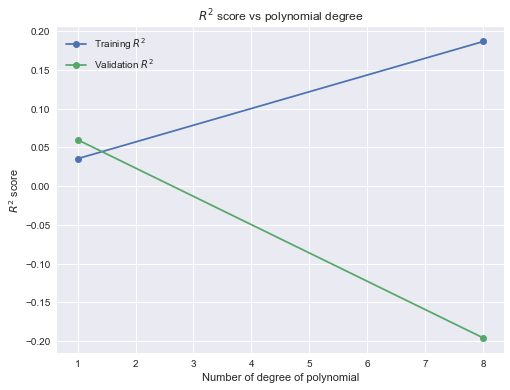

In [53]:
x = [1,N]
models = [model_1, model_N]
X_trains = [X_train_df, X_train_df_N]
X_vals = [X_val_df, X_val_df_N]

r2_train = []
r2_val = []

for i,model in enumerate(models):
    y_pred_tra = model.predict(sm.add_constant(X_trains[i]))
    y_pred_val = model.predict(sm.add_constant(X_vals[i]))
    r2_train.append(r2_score(y_train, y_pred_tra))
    r2_val.append(r2_score(y_val, y_pred_val))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, r2_train, 'o-', label=r'Training $R^2$')
ax.plot(x, r2_val, 'o-', label=r'Validation $R^2$')
ax.set_xlabel('Number of degree of polynomial')
ax.set_ylabel(r'$R^2$ score')
ax.set_title(r'$R^2$ score vs polynomial degree')
ax.legend();

R squared score for our original OLS model: -0.1959567607878241
R squared score for Ridge with alpha=2000: 0.020274830004442967


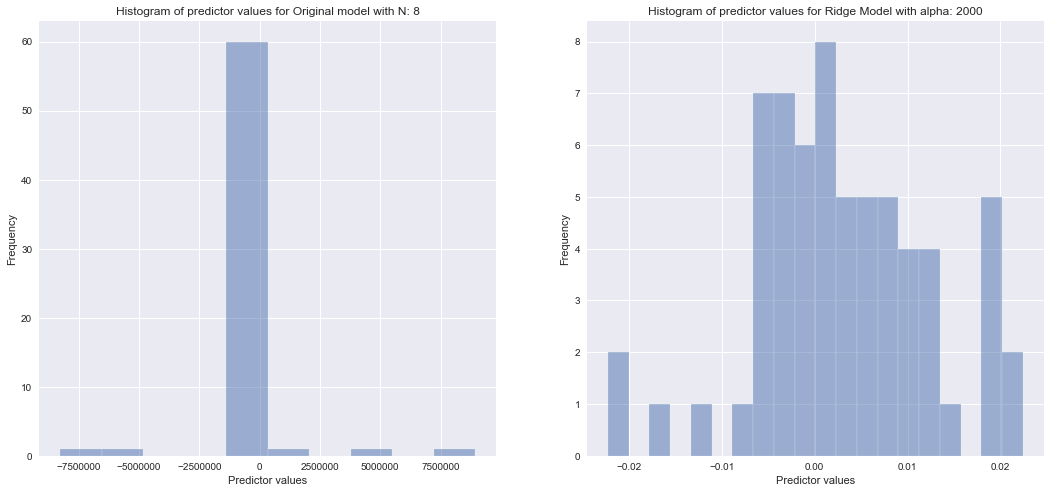

In [67]:
from sklearn.linear_model import Ridge, Lasso
# some values you can try out: 0.01, 0.1, 0.5, 1, 5, 10, 20, 40, 100, 200, 500, 1000, 10000
alpha = 2000
ridge_model = Ridge(alpha=alpha).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Ridge with alpha={}: {}'.format(alpha, ridge_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.params, bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(ridge_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Ridge Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

R squared score for our original OLS model: -0.1959567607878241
R squared score for Lasso with alpha=0.05: 0.049934215937047055


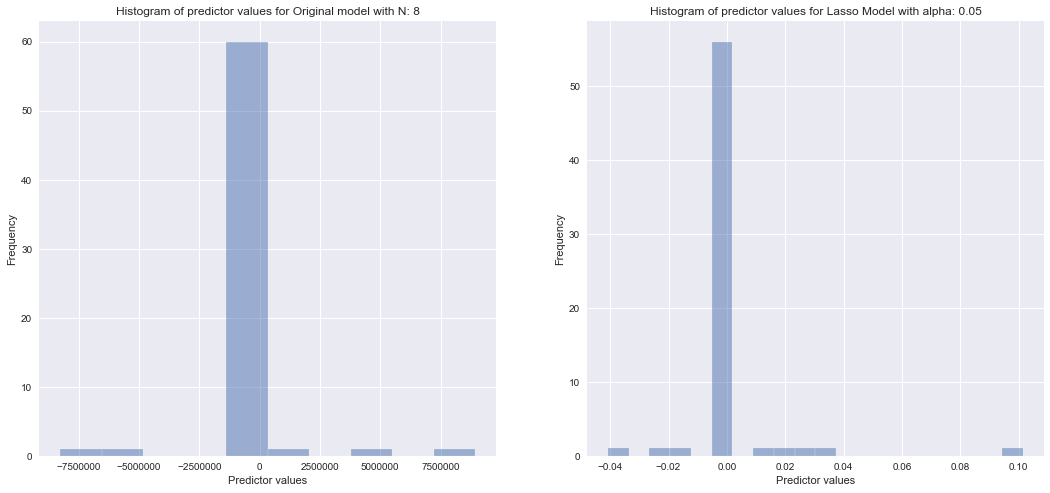

In [61]:
# some values you can try out: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20
alpha = 0.05
lasso_model = Lasso(alpha=alpha, max_iter = 1000).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Lasso with alpha={}: {}'.format(alpha, lasso_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.params, bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(lasso_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Lasso Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

In [71]:
alphas = (0.001, 0.01, 0.1, 10, 100, 1000, 10000)

# Let us do k-fold cross validation 
k = 4
fitted_ridge = RidgeCV(alphas=alphas).fit(X_train_df_N, y_train)
fitted_lasso = LassoCV(alphas=alphas).fit(X_train_df_N, y_train)

print('R^2 score for our original OLS model: {}\n'.format(r2_val[-1]))

ridge_a = fitted_ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, fitted_ridge.score(X_val_df_N,y_val)))

lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso with alpha={}: {}'.format(lasso_a, fitted_lasso.score(X_val_df_N,y_val)))

R^2 score for our original OLS model: -0.1959567607878241

Best alpha for ridge: 10000.0
R^2 score for Ridge with alpha=10000.0: 0.012701584168298807

Best alpha for lasso: 10000.0
R squared score for Lasso with alpha=10000.0: -0.0015758273558739155


In [74]:
list(zip(X_train_df_N.columns, fitted_ridge.coef_)

SyntaxError: unexpected EOF while parsing (<ipython-input-74-4fc8200acad8>, line 1)

In [ ]:
feats = ['no_of_words_title','ratings_count','reviews_count','text_reviews_count',
         'work_ratings_count','work_reviews_count','work_text_reviews_count','average_rating']

##### Top features by OLS by on p-values (<0.05): 
work_ratings_count, work_reviews_count, work_text_reviews_count

### Explore the relationships between variables

In [ ]:
corr = df_scaled.corr()
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, vmax=1., square=True)
plt.title('Correlation Relationships between Variables', fontsize=15)
plt.show()

##### Features that are highly correlated to each other:
* ratings_count and reviews_count
* ratings_count and text_reviews_count
* reviews_count and text_reviews_count

In [ ]:
# Calculate correlation of each feature to 'weeks_on_list' and sort in descending order
corr = df_scaled.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Target', 'level_1':'Features', 0:'Correlation_Values'})
corr = corr.loc[corr['Target'] == 'weeks_on_list']
corr.sort_values(by = 'Correlation_Values', ascending = False)

In [70]:
y = df_scaled['weeks_on_list']
X = df_scaled.drop(['weeks_on_list'], axis=1)
# Scale the features X on both the train and test sets
ss = StandardScaler()
ss.fit(X.values)
X_scaled = ss.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3, 3, 200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# Print out the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )
# Display all coefficients in the model with optimal alpha
list(zip(X.columns, lasso_model.coef_))

NameError: name 'df_scaled' is not defined